## Importing Libraries

In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

## Loading Data

In [5]:
data = pd.read_csv("Diamonds.csv")
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Data Preprocessing

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [7]:
#The first column seems to be just index
data = data.drop(["Unnamed: 0"], axis=1)
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Min value of "x", "y", "z" are zero this indicates that there are faulty values in data that represents dimensionless or 2-dimensional diamonds. So we need to filter out those as it clearly faulty data points.

In [8]:
#Dropping dimentionless diamonds
data = data.drop(data[data["x"]==0].index)
data = data.drop(data[data["y"]==0].index)
data = data.drop(data[data["z"]==0].index)
data.shape

(53920, 10)

We lost 20 data points by deleting the dimensionless(2-D or 1-D) diamonds.

**Handling Missing Data**

In [9]:
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

**Handling Outliers**

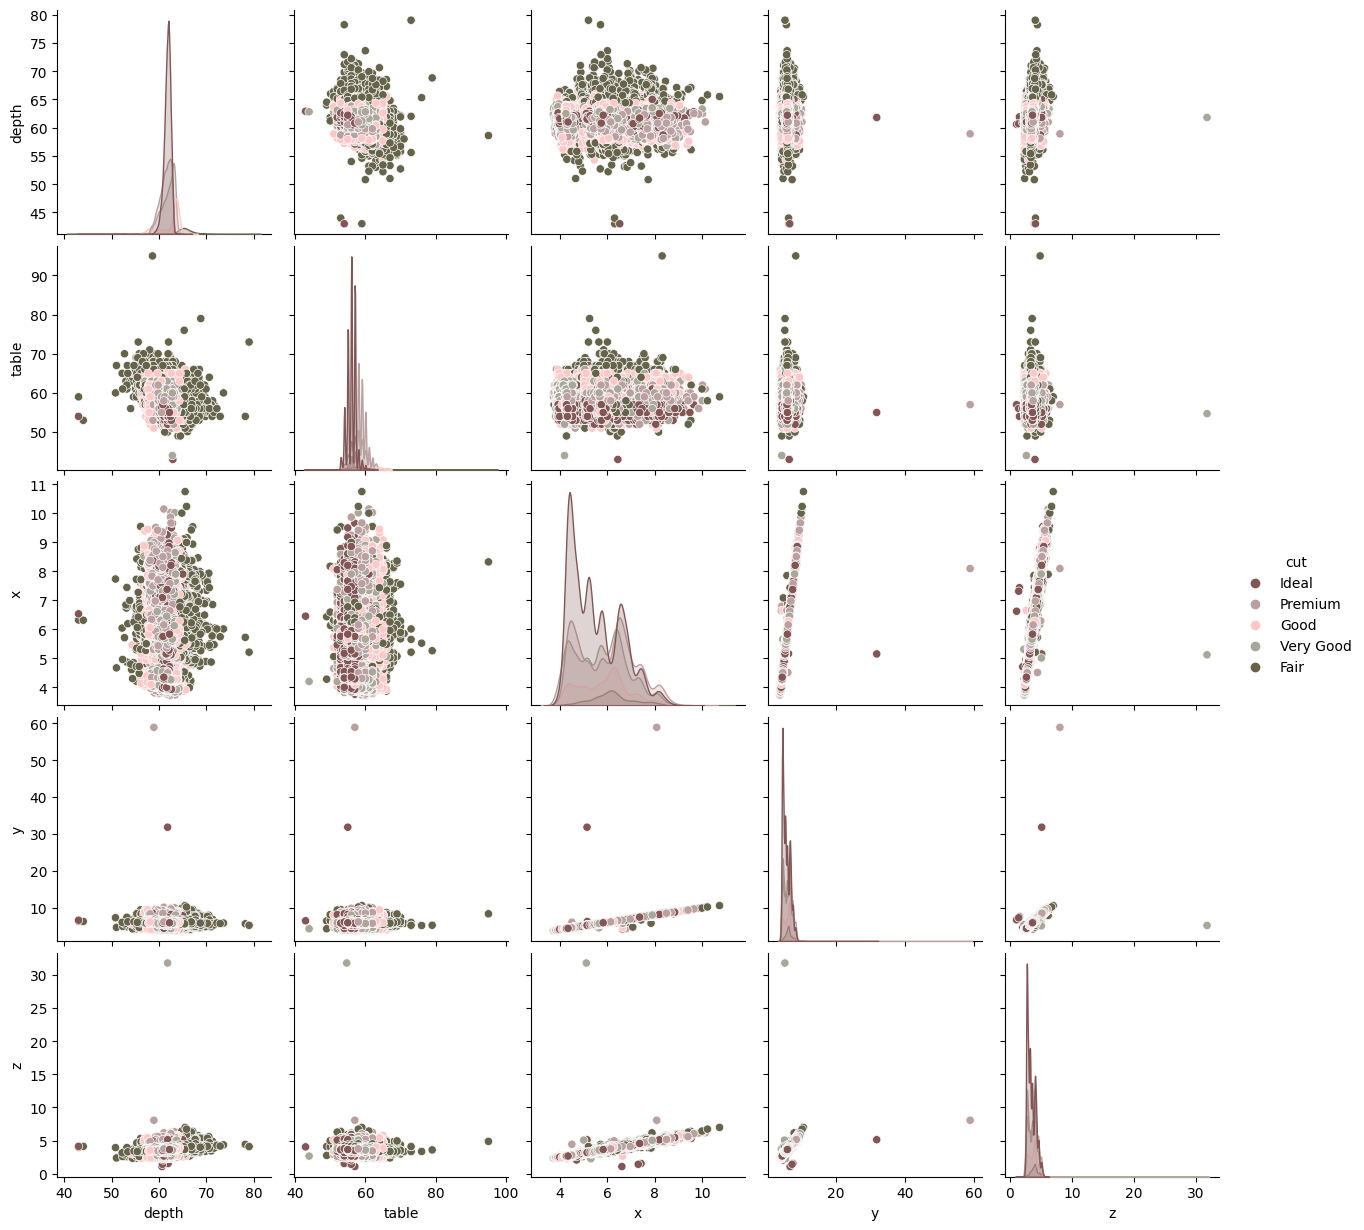

In [10]:
shade = ["#835656", "#baa0a0", "#ffc7c8", "#a9a799", "#65634a"]#shades for hue
ax = sns.pairplot(data[["cut","depth","table","x","y","z"]], hue= "cut",palette=shade)

There are some features with datapoint that are far from the rest of the dataset which will affect the outcome of our regression model.

* "y" and "z" have some dimensional outliers in our dataset that needs to be eliminated.
* The "depth" should be capped but we must examine the regression line to be sure.
* The "table" featured should be capped too.


In [11]:
#Dropping the outliers. 
data = data[(data["depth"]<75)&(data["depth"]>45)]
data = data[(data["table"]<80)&(data["table"]>40)]
data = data[(data["x"]<30)]
data = data[(data["y"]<30)]
data = data[(data["z"]<30)&(data["z"]>2)]
data.shape

(53907, 10)

**Feature Scaling**

In [12]:
# Get list of categorical variables
s = (data.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


In [13]:
label_data = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])

## EDA and Visualization

In [14]:
data.describe()

,carat,depth,table,price,x,y,z
count,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000,53907.000000
mean,0.797628,61.749741,57.455948,3930.584470,5.731463,5.733292,3.539441
std,0.473765,1.420119,2.226153,3987.202815,1.119384,1.111252,0.691434
min,0.200000,50.800000,43.000000,326.000000,3.730000,3.680000,2.060000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5322.000000,6.540000,6.540000,4.040000
max,5.010000,73.600000,79.000000,18823.000000,10.740000,10.540000,6.980000


**Distribution of Data**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22204\856741335.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data[col], shade=True, color='orange')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22204\856741335.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data[col], shade=True, color='orange')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22204\856741335.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data[col], shade=True, color='orange')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22204\856741335.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an

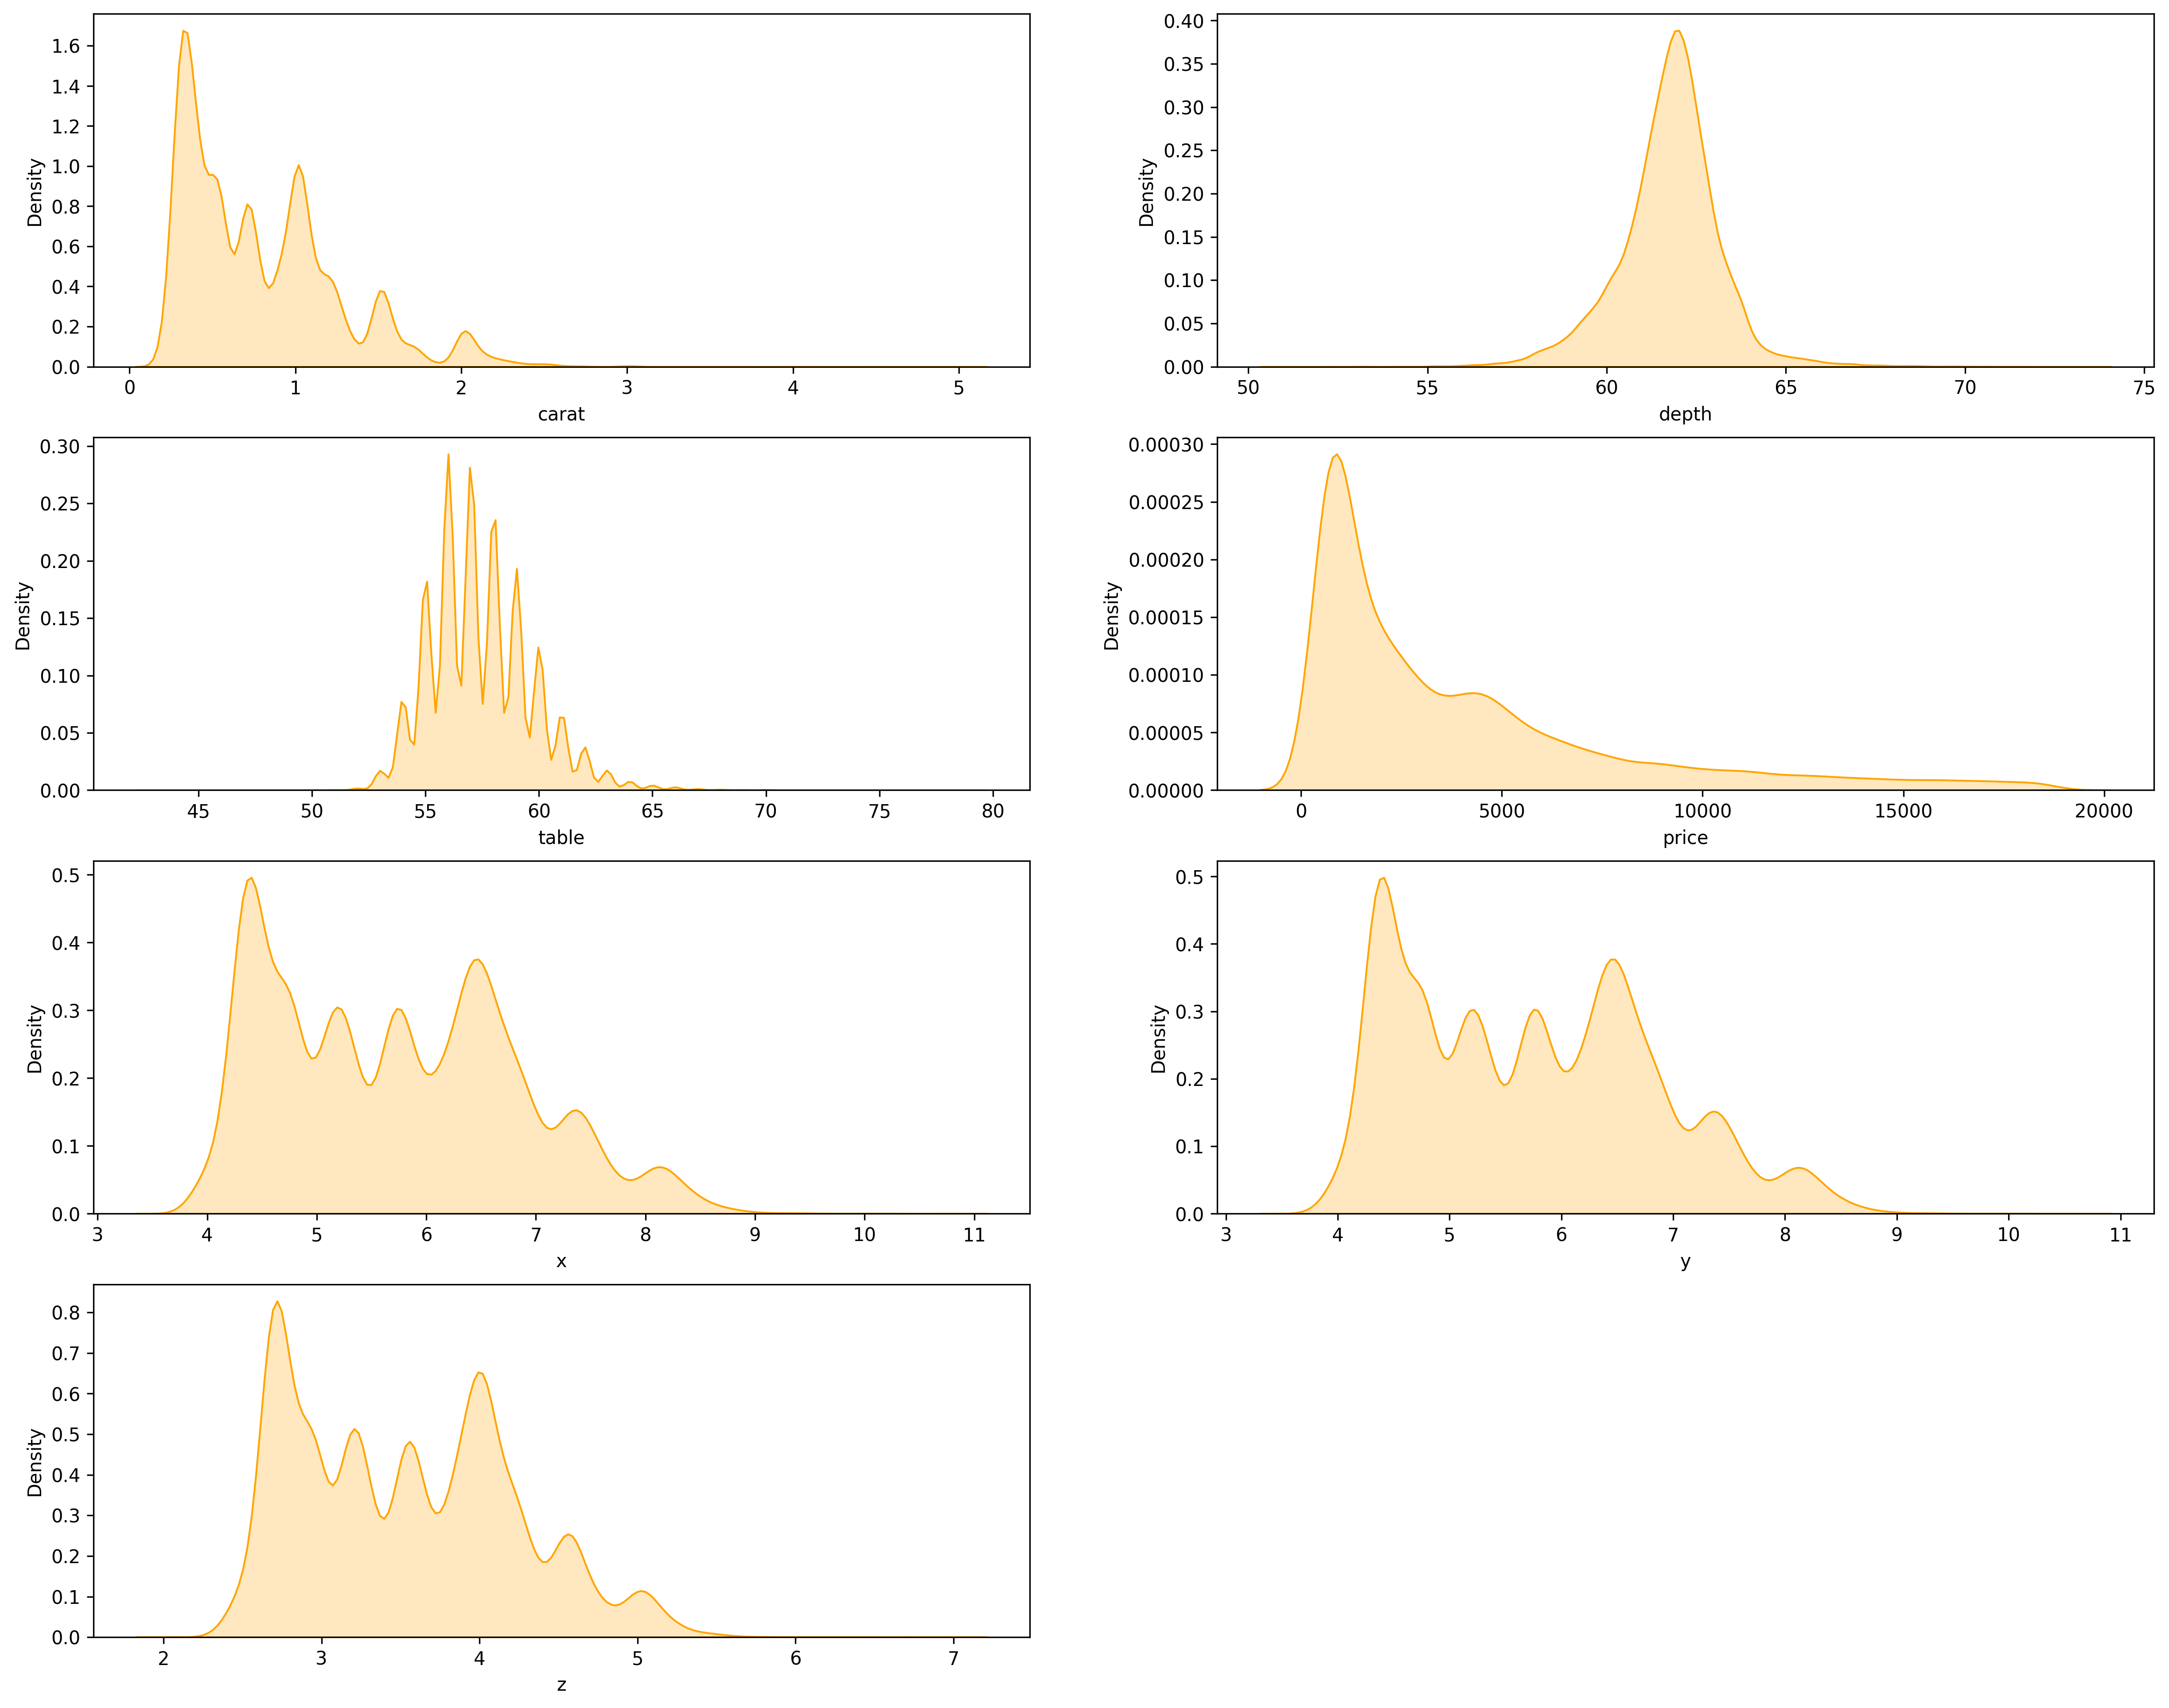

In [15]:
plt.figure(figsize=(20,20), dpi=300)
i=1
for col in ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']:
    plt.subplot(5,2,i)
    i+=1
    sns.kdeplot(x=data[col], shade=True, color='orange')

In [16]:
data.skew()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22204\1188251951.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.skew()


carat    1.116418
depth   -0.057712
table    0.705518
price    1.618641
x        0.398393
y        0.392833
z        0.395704
dtype: float64

**Dispersion of Data**

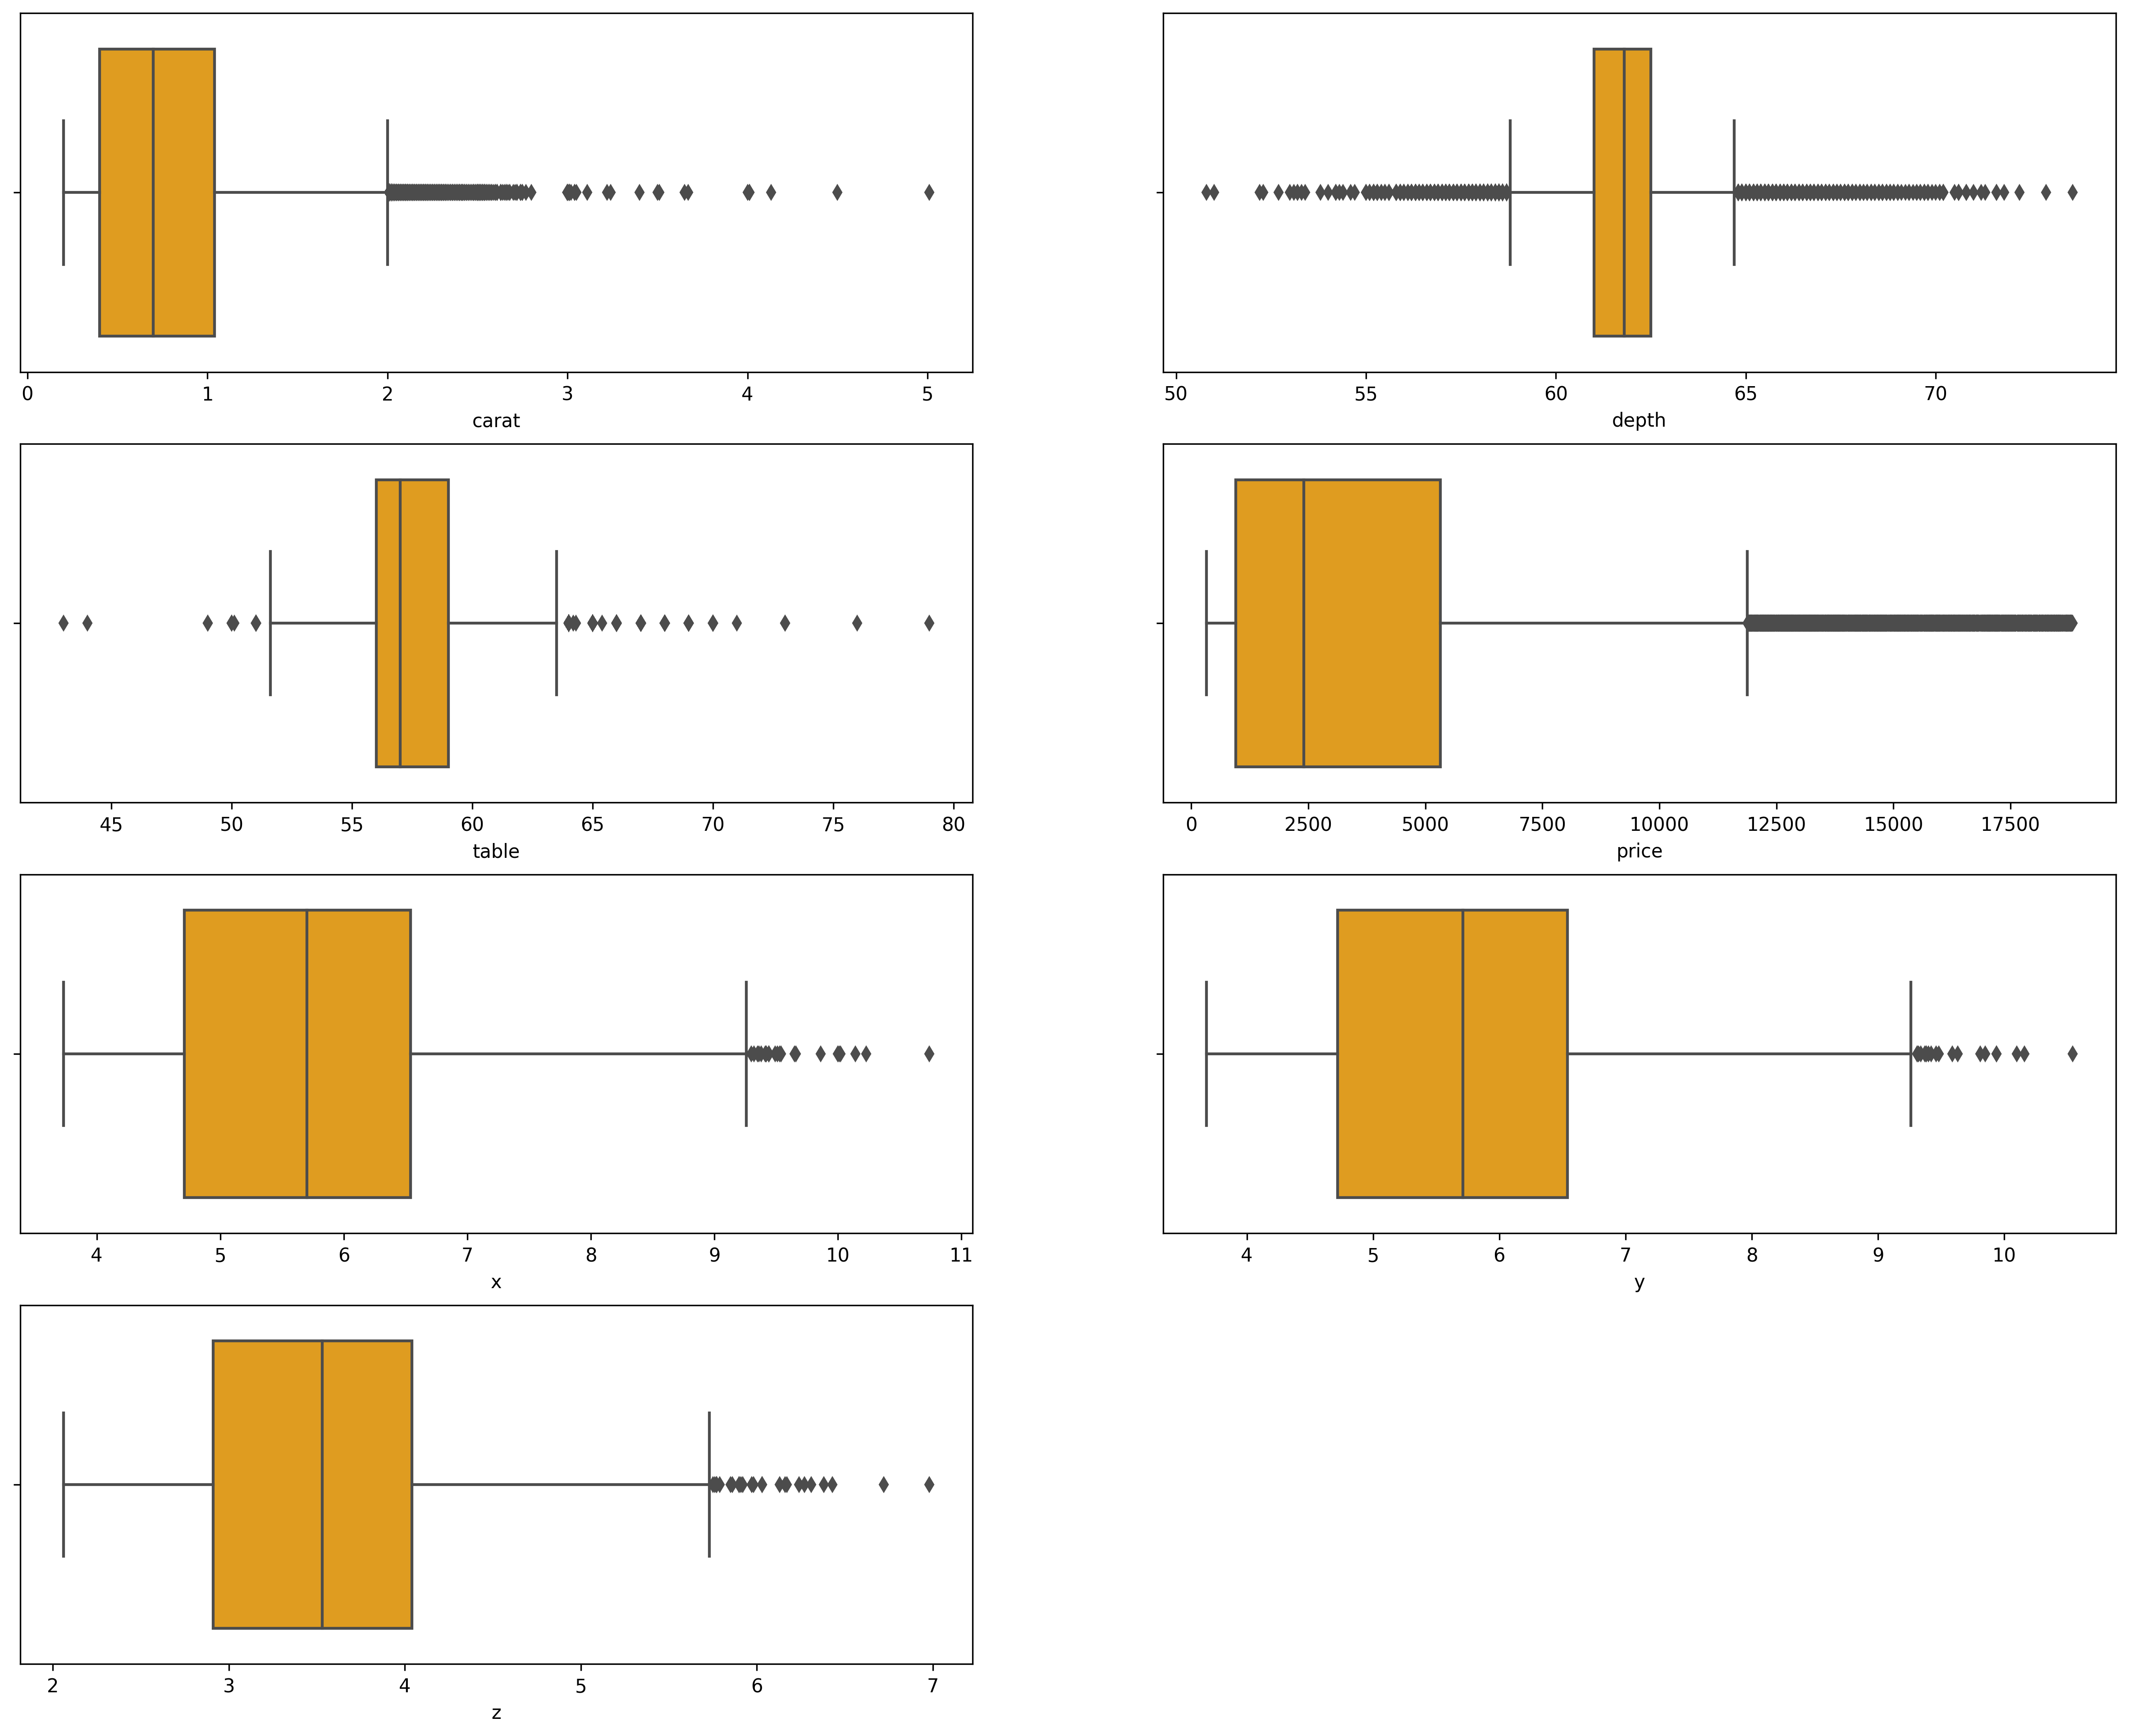

In [17]:
plt.figure(figsize=(20,20), dpi=300)
i=1
for col in ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']:
    plt.subplot(5,2,i)
    i+=1
    sns.boxplot(x=data[col], color='orange')

**Data Visualization**

<AxesSubplot:xlabel='carat', ylabel='price'>

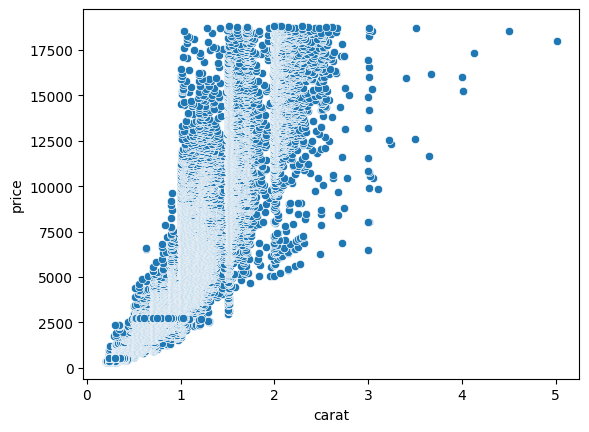

In [18]:
sns.scatterplot(x=data.carat, y=data.price)

<AxesSubplot:xlabel='carat', ylabel='Count'>

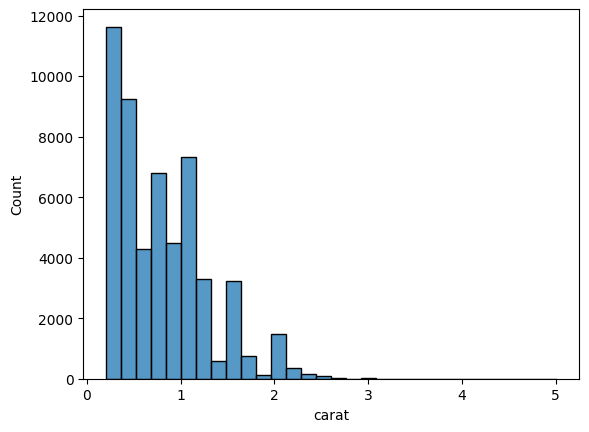

In [19]:
sns.histplot(x=data.carat, bins=30)

<AxesSubplot:xlabel='cut', ylabel='count'>

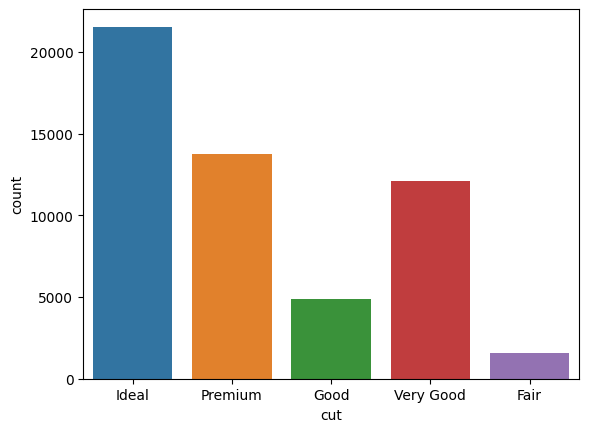

In [20]:
sns.countplot(x=data.cut)

<AxesSubplot:xlabel='cut', ylabel='price'>

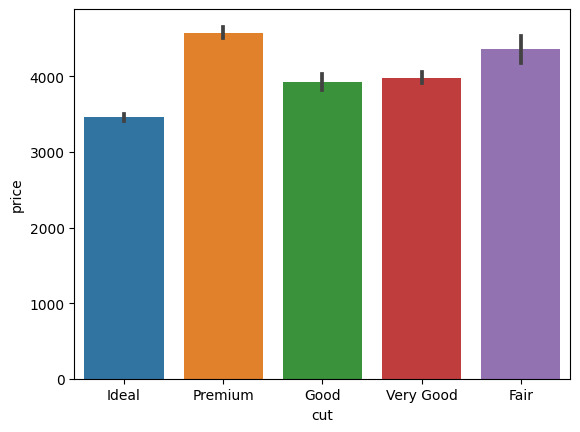

In [21]:
sns.barplot(x=data.cut, y=data.price)

<AxesSubplot:xlabel='color', ylabel='count'>

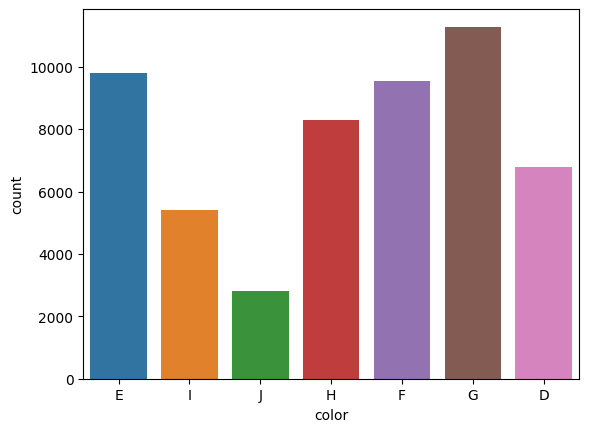

In [22]:
sns.countplot(x=data.color)

<AxesSubplot:xlabel='color', ylabel='price'>

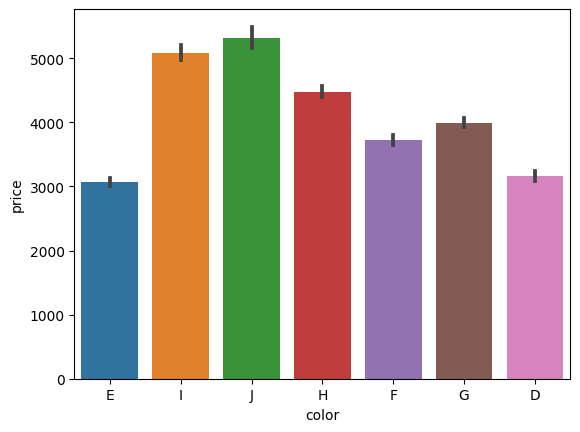

In [23]:
sns.barplot(x=data.color, y=data.price)

<AxesSubplot:xlabel='clarity', ylabel='count'>

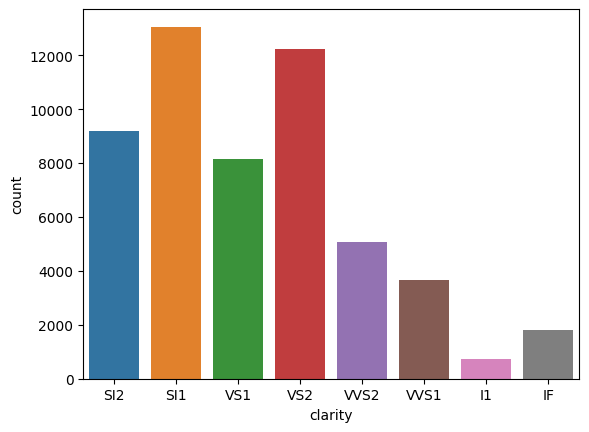

In [24]:
sns.countplot(x=data.clarity)

<AxesSubplot:xlabel='clarity', ylabel='price'>

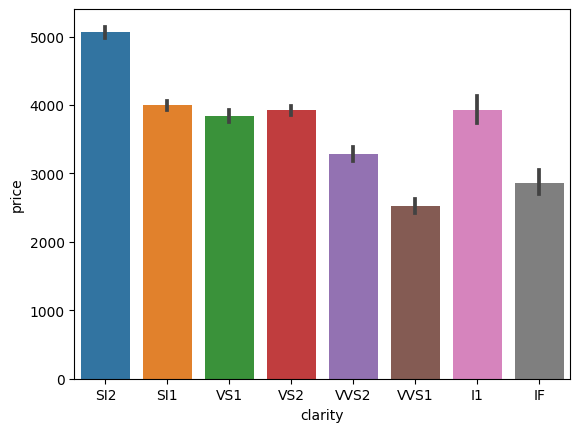

In [25]:
sns.barplot(x=data.clarity, y=data.price)

<AxesSubplot:xlabel='x', ylabel='Count'>

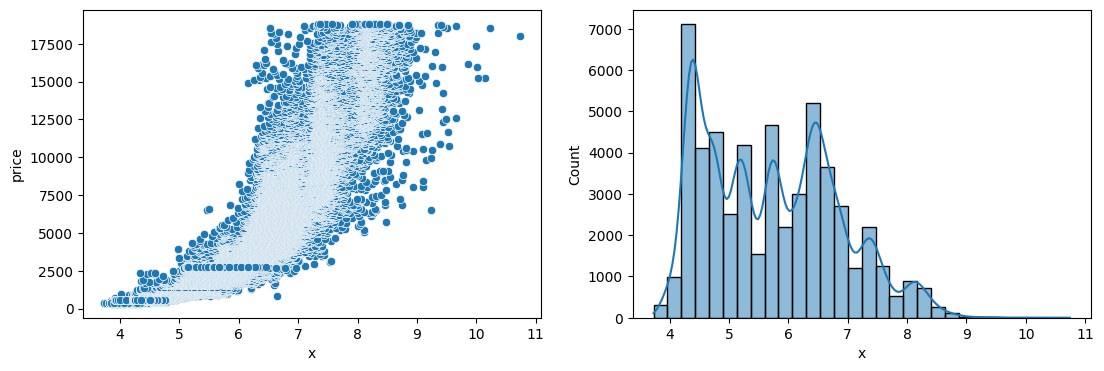

In [26]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
sns.scatterplot(x=data.x, y=data.price)
plt.subplot(1,2,2)
sns.histplot(x=data.x, bins=30, kde=True)

**Correlation Analysis**

<AxesSubplot:>

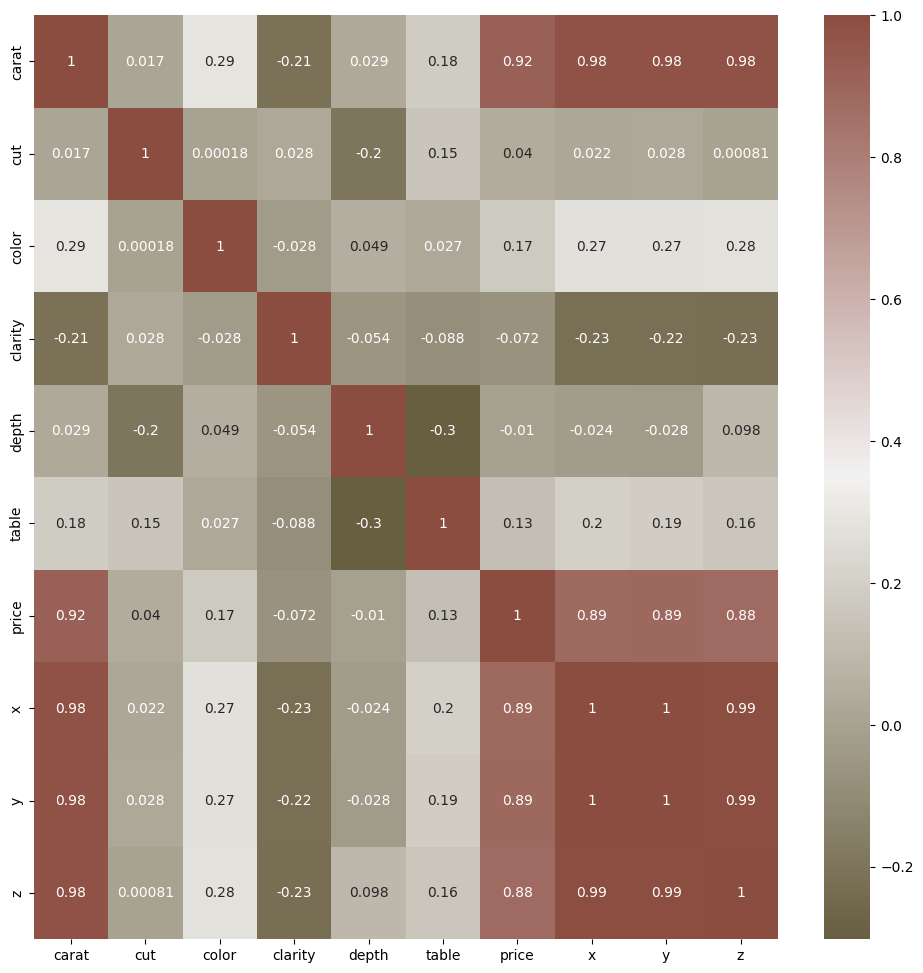

In [27]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

**Inferences:**
* "x", "y" and "z" show a high correlation to the target column.
* "depth", "cut" and "table" show low correlation. We could consider dropping but let's keep it.

## Model Building and Selection

**Train-Test Split**

In [28]:
# Assigning the featurs as X and trarget as y
X= label_data.drop(["price"],axis =1)
y= label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

**Building Various Model Pipelines**

In [29]:
# Building pipelins of standard scaler and model for varios regressors.
pipeline_lr=Pipeline([("scalar1",StandardScaler()), ("lr_classifier",LinearRegression())])
pipeline_rf=Pipeline([("scalar2",StandardScaler()), ("rf_classifier",RandomForestRegressor())])
pipeline_kn=Pipeline([("scalar3",StandardScaler()), ("rf_classifier",KNeighborsRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_rf, pipeline_kn]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "RandomForest",2: "KNeighbors"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [30]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -1343.894224 
RandomForest: -551.293160 
KNeighbors: -818.645061 


In the above scores, KNeighborsRegressor appears to be the model with the best scoring on negative root mean square error. Let's test this model on a test set and evaluate it with different parameters.

## Results and Performance Measures

In [31]:
# Model prediction on test data
pred = pipeline_kn.predict(X_test)

In [32]:
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.9577713844261662
Adjusted R^2: 0.9577361024413755
MAE: 406.4764051196438
MSE: 657759.979243183
RMSE: 811.0240312365491
